В сервисе по доставке продуктов была настроена фронтовая аналитика в AppMetrica. Необходимо проанализировать поведение пользователей сервиса, оценить эффективность каналов их привлечения, а также ответить на ряд вопросов по ходу задания. 

##### Примечание:
- Сервис доступен как в приложении на ios, так и на android 
- В выгрузке только уникальные действия пользователей за каждый день 
- Можно миновать стадию установки приложения, если оно было установлено ранее
- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

In [1]:
# Импорт требуемых библиотек

import pandas as pd
import numpy as np

import plotly.express as px
from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-h-gajzetdinova/KC_case_data .csv', parse_dates=['date'])

In [3]:
# Обзор датафрейма 

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   event         object        
 2   purchase_sum  float64       
 3   os_name       object        
 4   device_id     int64         
 5   gender        object        
 6   city          object        
 7   utm_source    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 167.7+ MB


,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [4]:
# Вывод уникальных статусов пользователей

data.event.unique()

array(['app_start', 'choose_item', 'purchase', 'search', 'tap_basket',
       'app_install', 'register'], dtype=object)

***1. Найти MAU февраля*** (количество уникальных пользователей, которые взаимодействуют с сервисом в течение месяца):

In [5]:
# Вывод месяца из даты 

data['month'] = data.date.dt.month_name() 
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January


In [6]:
# Вывод MAU для кажого месяца

mau = data.groupby('month').device_id.nunique()
mau

month
February    75032
January     99161
March       74623
Name: device_id, dtype: int64

***2. Найти количество установок в январе:***

In [7]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January


In [8]:
# Вывод установок совершенных в январе

number_install = data.query('event == "app_install"')\
                .groupby('month', as_index=False)\
                .agg({'device_id': 'nunique'})\
                .rename(columns={'device_id': 'count_install'})
number_install

,month,count_install
0,February,38078
1,January,80297
2,March,36222


***3. Присвойте пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку в течение 7 дней.***

Для какой когорты конверсия была наибольшей?

Примечание: считаем пользователя сконвертировавшимся, 
если с момента установки до совершения первой покупки прошло не более 7 дней.



In [9]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January


In [10]:
# Найдем дату установки приложения для каждого пользователя

date_install = data.query('event == "app_install"')\
                    .groupby('device_id', as_index=False)\
                    .agg({'date': 'min'})\
                    .rename(columns={'date': 'date_install'})
date_install.head()

,device_id,date_install
0,4013,2020-01-15
1,4016,2020-01-04
2,4046,2020-01-04
3,4065,2020-03-19
4,4067,2020-01-31


In [11]:
# Найдем дату первой покупки приложения для каждого пользователя

date_purchase = data.query('event == "purchase"')\
                    .groupby('device_id', as_index=False)\
                    .agg({'date': 'min'})\
                    .rename(columns={'date': 'date_purchase'})
date_purchase.head()

,device_id,date_purchase
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4120,2020-01-07
4,4125,2020-01-07


In [12]:
# Объединим информацию с датами в один дф

first_date = date_install.merge(date_purchase, on = 'device_id', how = 'inner')
first_date.head()

,device_id,date_install,date_purchase
0,4046,2020-01-04,2020-01-04
1,4120,2020-01-07,2020-01-07
2,4125,2020-01-07,2020-01-07
3,4202,2020-01-08,2020-02-27
4,4234,2020-02-19,2020-02-19


In [13]:
# Нашли разницу в днях между датой установки и покупки. Если дата = неделя, то Yes, или No

first_date['week'] = (first_date['date_purchase'] - first_date['date_install']) 
first_date['week'] = np.where(first_date['week'] > '7 days', 'no', 'yes')
first_date = first_date.query('week == "yes"')
first_date.head()

,device_id,date_install,date_purchase,week
0,4046,2020-01-04,2020-01-04,yes
1,4120,2020-01-07,2020-01-07,yes
2,4125,2020-01-07,2020-01-07,yes
4,4234,2020-02-19,2020-02-19,yes
5,4244,2020-03-19,2020-03-19,yes


In [14]:
# Посчитали количество установок для сконвертировавшихся пользователей за неделю

count_install = first_date\
                .groupby('date_install', as_index=False)\
                .agg({'device_id': 'count'})\
                .sort_values('date_install')\
                .rename(columns={'device_id':'install_devise', 'date_install': 'date'})
count_install.head()

,date,install_devise
0,2020-01-01,1408
1,2020-01-02,1186
2,2020-01-03,834
3,2020-01-04,639
4,2020-01-05,587


In [15]:
# Посчитали общее количество действий для каждй когорты (даты установки)

date_group = data.groupby('date', as_index=False)\
                .agg({'device_id': 'nunique'})\
                .sort_values('date')\
                .rename(columns={'device_id':'total_device'})
date_group.head()

,date,total_device
0,2020-01-01,4445
1,2020-01-02,5104
2,2020-01-03,5144
3,2020-01-04,4925
4,2020-01-05,5608


***4. Укажите значение CR из предыдущего вопроса в % (округлите до 1 цифры после запятой).***

In [16]:
# Соединили два дф в один для подсчета конверсии

total_install_device = date_group.merge(count_install, on = 'date')
total_install_device.head()

,date,total_device,install_devise
0,2020-01-01,4445,1408
1,2020-01-02,5104,1186
2,2020-01-03,5144,834
3,2020-01-04,4925,639
4,2020-01-05,5608,587


In [17]:
# Вывод CR (отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей)

total_install_device['cr'] = round(total_install_device['install_devise'] / total_install_device['total_device']*100, 2)
total_install_device = total_install_device.sort_values('cr', ascending=False)
total_install_device.head()

,date,total_device,install_devise,cr
0,2020-01-01,4445,1408,31.68
1,2020-01-02,5104,1186,23.24
9,2020-01-10,21431,4161,19.42
2,2020-01-03,5144,834,16.21
13,2020-01-14,12943,1973,15.24


***5. С какого платного маркетингового канала пришло больше всего новых пользователей?***

In [18]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January


In [19]:
# Сортировка каналов по количеству уникальных посетителей

data.groupby('utm_source', as_index=False) \
    .agg({'device_id':'nunique'}) \
    .sort_values('device_id', ascending=False)

,utm_source,device_id
0,-,52273
6,yandex-direct,40712
2,google_ads,38096
5,vk_ads,34086
3,instagram_ads,31048
1,facebook_ads,25959
4,referal,15926


***5. Проанализируйте на каком этапе воронки отваливается бОльшая часть клиентов.***

In [20]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January


In [21]:
data.event.value_counts()

app_start      748705
search         708639
choose_item    538669
tap_basket     377665
app_install    154597
purchase       141383
register        78310
Name: event, dtype: int64

In [22]:
# Вывод даты регистрации для каждого пользователя

data_registr = data.query('event == "register"').sort_values('date').drop_duplicates('device_id')
data_registr.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
2669658,2020-01-01,register,NaN,ios,294193,female,Saint-Petersburg,instagram_ads,January
2670356,2020-01-01,register,NaN,ios,21780,female,Saint-Petersburg,yandex-direct,January
2670357,2020-01-01,register,NaN,ios,2470180,male,Moscow,google_ads,January
2670358,2020-01-01,register,NaN,android,3735668,male,Moscow,instagram_ads,January
2670359,2020-01-01,register,NaN,android,11372938,male,Saint-Petersburg,-,January


In [23]:
data['first_registration'] = data.device_id.map(data_registr.set_index('device_id')['date'])
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January,2020-01-07
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January,NaT


In [24]:
# Вывод только зарегистрированных пользователей, которые после совершают какое-либо целевое действие

already_reg = data.query('first_registration < date')
already_reg.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration
15148,2020-01-02,app_start,NaN,ios,3163406,female,Moscow,instagram_ads,January,2020-01-01
15175,2020-01-02,app_start,NaN,ios,2169108,female,Moscow,google_ads,January,2020-01-01
15197,2020-01-02,app_start,NaN,android,4863305,male,Saint-Petersburg,vk_ads,January,2020-01-01
15210,2020-01-02,app_start,NaN,android,15248490,male,Moscow,facebook_ads,January,2020-01-01
15214,2020-01-02,app_start,NaN,ios,25617659,male,Moscow,vk_ads,January,2020-01-01


In [25]:
# Подсчет количества пользователей на каждом шаге

funnel = (already_reg.
          groupby('event', as_index=False).
          agg({'device_id': 'nunique'}).
          rename(columns={'device_id' : 'total_users'}).
          sort_values(by='total_users', ascending=False))

funnel

,event,total_users
0,app_start,40991
3,search,40482
1,choose_item,37926
4,tap_basket,34517
2,purchase,24880


In [27]:
# Построим воронку событий

fig = go.Figure(go.Funnel(x=funnel['total_users'], 
                          y=funnel['event'], 
                          opacity = 0.6, 
                          textposition = "inside", 
                          textinfo = "value+percent previous",))
fig.update_layout(title_text='Воронка событий')
fig.show()

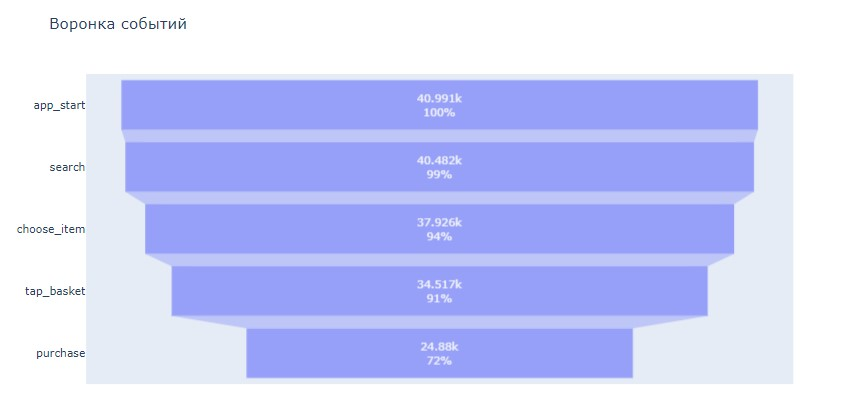

***6. Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?***

In [28]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,January,2020-01-07
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,January,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,January,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,January,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,January,NaT


In [29]:
# Посчитаем кол-во юзеров, впервые совершивших покупку

CR1 = data.query('event == "purchase"').groupby('utm_source', as_index=False).agg({'device_id': 'nunique'})\
        .rename(columns={'device_id':'purchase'})
CR1.head()

,utm_source,purchase
0,-,16598
1,facebook_ads,9017
2,google_ads,11339
3,instagram_ads,10762
4,referal,6362


In [30]:
# Посчитаем кол-во юзеров, впервые открывших приложение 

CR2 = data.query('event == "app_start"').groupby('utm_source', as_index=False).agg({'device_id': 'nunique'})\
            .rename(columns={'device_id':'app_start'})
CR2.head()

,utm_source,app_start
0,-,52268
1,facebook_ads,25957
2,google_ads,38092
3,instagram_ads,31045
4,referal,15924


In [31]:
# Вывод CR

CR = CR1.merge(CR2, on='utm_source')
CR['CR'] = round((CR['purchase'] / CR['app_start'])*100, 2)
CR.sort_values('CR')

,utm_source,purchase,app_start,CR
6,yandex-direct,12028,40707,29.55
2,google_ads,11339,38092,29.77
0,-,16598,52268,31.76
3,instagram_ads,10762,31045,34.67
1,facebook_ads,9017,25957,34.74
5,vk_ads,12364,34079,36.28
4,referal,6362,15924,39.95


***7. Пользователи, пришедшие с какого канала, имеют медианный первый чек выше? (учитываются только первые покупки пользователей)***

In [32]:
# Вывод действией со статусом "покупка"

data = data.query('event == "purchase"').sort_values('date')
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration
7691,2020-01-01,purchase,265.5,android,6081155,female,Moscow,-,January,2020-01-01
8289,2020-01-01,purchase,292.0,ios,1955306,female,Moscow,yandex-direct,January,2020-01-01
8290,2020-01-01,purchase,664.0,ios,20176327,female,Moscow,facebook_ads,January,2020-01-01
8291,2020-01-01,purchase,337.0,android,28603960,male,Moscow,-,January,2020-01-01
8292,2020-01-01,purchase,502.0,ios,14028316,female,Moscow,referal,January,2020-01-01


In [33]:
# Нахождение первой покупки для каждого девайса

first_purchase = data.groupby('device_id', as_index=False).agg({'date': 'min'})
first_purchase.head()

,device_id,date
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4120,2020-01-07
4,4125,2020-01-07


In [34]:
# Склеивание общего дф

avg_check = data.merge(first_purchase, on = ['device_id', 'date'])
avg_check.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration
0,2020-01-01,purchase,265.5,android,6081155,female,Moscow,-,January,2020-01-01
1,2020-01-01,purchase,292.0,ios,1955306,female,Moscow,yandex-direct,January,2020-01-01
2,2020-01-01,purchase,664.0,ios,20176327,female,Moscow,facebook_ads,January,2020-01-01
3,2020-01-01,purchase,337.0,android,28603960,male,Moscow,-,January,2020-01-01
4,2020-01-01,purchase,502.0,ios,14028316,female,Moscow,referal,January,2020-01-01


In [35]:
# нахождение медианного чека по каналам

avg_check = (avg_check.
             groupby('utm_source', as_index=False).
             agg({'purchase_sum': 'median'}).
             sort_values('purchase_sum', ascending=False).
             rename(columns={'purchase_sum': 'purchase_avg'}))
avg_check

,utm_source,purchase_avg
0,-,398.5
4,referal,395.5
3,instagram_ads,393.5
5,vk_ads,393.0
6,yandex-direct,392.5
2,google_ads,390.5
1,facebook_ads,389.0


***12. Какой платный канал привлечения (среди рекламных) имеет самый высокий ROMI?***

In [36]:
data.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration
7691,2020-01-01,purchase,265.5,android,6081155,female,Moscow,-,January,2020-01-01
8289,2020-01-01,purchase,292.0,ios,1955306,female,Moscow,yandex-direct,January,2020-01-01
8290,2020-01-01,purchase,664.0,ios,20176327,female,Moscow,facebook_ads,January,2020-01-01
8291,2020-01-01,purchase,337.0,android,28603960,male,Moscow,-,January,2020-01-01
8292,2020-01-01,purchase,502.0,ios,14028316,female,Moscow,referal,January,2020-01-01


In [37]:
# Вывод стоимости покупок по каждому каналу привлечения 

sourse_purchase = data.groupby('utm_source', as_index=False).agg({'purchase_sum': 'sum'})
sourse_purchase

,utm_source,purchase_sum
0,-,21449749.5
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


In [38]:
# Создание датафрейма с данными по затратам на рекламу

expenses = [['yandex-direct', 10491707], ['google_ads', 10534878], ['facebook_ads', 8590498], ['instagram_ads', 8561626], ['vk_ads', 9553531]]

In [39]:
df = pd.DataFrame(expenses,  columns=['utm_source', 'expenses_sum'])
df

,utm_source,expenses_sum
0,yandex-direct,10491707
1,google_ads,10534878
2,facebook_ads,8590498
3,instagram_ads,8561626
4,vk_ads,9553531


In [40]:
df1 = df.merge(sourse_purchase, on = 'utm_source').sort_values('purchase_sum', ascending=False)

In [41]:
df1.head()

,utm_source,expenses_sum,purchase_sum
4,vk_ads,9553531,16389652.5
3,instagram_ads,8561626,14546969.0
0,yandex-direct,10491707,13915368.0
1,google_ads,10534878,12868276.0
2,facebook_ads,8590498,12249901.0
